In [1]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [2]:
import os
import cv2
import time
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

# data augmentation
import albumentations as A

# pretrained models
import torchvision
from torchvision import models, transforms

In [3]:
data_path = '../data/sourse2/Face_Mask_Dataset'

rows = []
for dataset in os.listdir(data_path):
    for label in os.listdir(data_path + f'/{dataset}'):
        for image in os.listdir(data_path + f'/{dataset}' + f'/{label}'):
            row = dict()
            row['image_file'] = image
            row['label'] = label
            row['dataset'] = dataset
        
            # a bit redudant, could build from other data in __getitem__ if wanted
            row['image_path'] = data_path + f'/{dataset}' + f'/{label}'
            row['sourse'] = 1
            rows.append(row)

data_path_2 = '../data/sourse3/Data'
for label in os.listdir(data_path_2):
    for image in os.listdir(data_path_2 + f'/{label}'):
        row = dict()
        row['image_file'] = image
        row['label'] = label
        row['dataset'] = 'None'

        # a bit redudant, could build from other data in __getitem__ if wanted
        row['image_path'] = data_path_2 + f'/{label}'
        row['sourse'] = 2
        rows.append(row)

df = pd.DataFrame(rows)
print(len(df))
df.head()

13168


,image_file,label,dataset,image_path,sourse
0,2734.png,WithoutMask,Test,../data/sourse2/Face_Mask_Dataset/Test/Without...,1
1,4345.png,WithoutMask,Test,../data/sourse2/Face_Mask_Dataset/Test/Without...,1
2,4423.png,WithoutMask,Test,../data/sourse2/Face_Mask_Dataset/Test/Without...,1
3,2052.png,WithoutMask,Test,../data/sourse2/Face_Mask_Dataset/Test/Without...,1
4,3364.png,WithoutMask,Test,../data/sourse2/Face_Mask_Dataset/Test/Without...,1


In [4]:
df.label.value_counts()

WithoutMask    6595
WithMask       6573
Name: label, dtype: int64

In [5]:
# test set for comparison
train_df,test_df = train_test_split(df, test_size=0.2, random_state=42)

In [6]:
def resize_img(path, size):
    img = cv2.imread(path)
    
    start = time.time()
    img = cv2.resize(img, size)
    end = time.time()
    
    cv2.imwrite(path, img)
    return end - start

# resize all of the images to 256x256
total_time_resize = 0.0
for idx in tqdm(range(len(df))):
    row = df.iloc[idx]
    image_path = row['image_path']
    fname = row['image_file']
    path = image_path+'/'+fname
    
    total_time_resize += resize_img(path, (256, 256))

  0%|          | 0/13168 [00:00<?, ?it/s]

WithoutMask


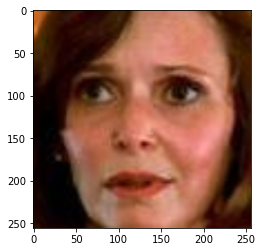

In [7]:
row = train_df.iloc[1000]
image_path = row['image_path']
fname = row['image_file']
label = row['label']
path = image_path+'/'+fname
img = cv2.imread(path)
out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
plt.imshow(out_img)
print(label)

In [8]:
from albumentations.pytorch import ToTensorV2

# let's add an augmentation option
class FaceMaskDataset(Dataset):
    def __init__(self, df, augment=False):
        self.df = df
        self.augment = augment
        
        # label dictionary
        self.label_dict = {'WithoutMask':0, 'WithMask':1}
        
        # define the transformation
        if augment == True:
            self.transforms = A.Compose([
                # spatial transforms
                A.PadIfNeeded(min_height=256, min_width=256,p=1),
                A.RandomCrop(width=224, height=224),
                A.HorizontalFlip(p=.5),
                A.VerticalFlip(p=.5),
                A.Rotate(limit = 10, 
                         border_mode = cv2.BORDER_CONSTANT, 
                         value = 0.0, p = .75),
                
                # pixel-level transformation
                A.RandomBrightnessContrast(p=0.5),
                
                # we will normalize according to ImageNet since we will be using a pre-trained ResNet
                # this adjusts from [0,255] to [0,1]
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                
                # convert to a tensor and move color channels
                ToTensorV2()
            ])
        else:
            self.transforms = A.Compose([
                # training/valid images have same size
                A.PadIfNeeded(min_height=256, min_width=256,p=1),
                A.CenterCrop(width=224, height=224),
                
                # normalize
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                
                # convert to a tensor and move color channels
                ToTensorV2()
            ])
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # get ingredients for retrieving image
        image_path = row['image_path']
        fname = row['image_file']
        path = image_path+'/'+fname
        
        # read the img
        img = cv2.imread(path)
        
        # convert to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # transform the image
        # certain transformations expect the uint8 datatype
        transformed = self.transforms(image=img.astype(np.uint8))
        img = transformed['image']
        
        label = torch.tensor(self.label_dict[row['label']])
        
        return img, label

# Comparison 1 subdataset (fake mask)

In [ ]:
# Balance test dataset

In [67]:
test_df.sourse.value_counts()

1    2364
2     270
Name: sourse, dtype: int64

In [71]:
set1  = test_df[test_df['sourse']==1].sample(n=270, random_state=42)
set2  = test_df[test_df['sourse']==2]
validation_set = pd.concat([set1,set2])

In [46]:
train_df_sourse2 = train_df[train_df['sourse']==2]
#sourse2_train,sourse2_valid = train_test_split(train_df_sourse2, test_size=0.2, random_state=42)

In [73]:
ds_train = FaceMaskDataset(train_df_sourse2, augment=False)
dl_train = DataLoader(ds_train, batch_size = 32, shuffle=True)

ds_val = FaceMaskDataset(validation_set)
dl_val = DataLoader(ds_val, batch_size = 32, shuffle=True)

In [74]:
next(iter(dl_train))[0].shape

torch.Size([32, 3, 224, 224])

torch.Size([3, 224, 224])
tensor(1)


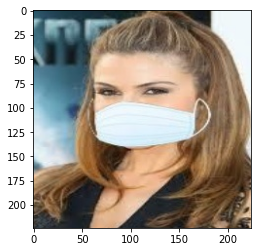

In [75]:
img, label = ds_train[105]
print(img.shape)

# restructure for plt
img = np.transpose(np.array(img), (1,2,0))

# reverse the normalization
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
for i in range(3):
    img[:,:,i] = (img[:,:,i] * std[i]) + mean[i]

plt.imshow(img)
print(label)

In [76]:
from MobileNetV2 import mobilenet_v2

net = mobilenet_v2(pretrained=True)

In [77]:
for param in net.parameters():
    param.requires_grad = False

In [78]:
print(net.classifier)

Linear(in_features=1280, out_features=1000, bias=True)


In [79]:
net.classifier = nn.Linear(1280,2)

In [80]:
print(net.classifier)

Linear(in_features=1280, out_features=2, bias=True)


In [81]:
for param in net.parameters():
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True


In [82]:
params_to_update = []

for param in net.parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

optimizer = optim.Adam(params_to_update, lr=0.001)

In [83]:
def one_pass(model, dataloader, optimizer, lossFun, backwards=True, print_loss=False):
    
    if backwards == True:
        model.train()
    else:
        model.eval()
    
    total_loss = 0.0
    for x, y in tqdm(dataloader):
        
        y_pred = model(x)
        loss = lossFun(y_pred, y)
        total_loss += loss.item()
        
        if backwards == True:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    avg_loss = total_loss / len(dataloader)
    
    if print_loss == True:
        print(avg_loss)
    
    return avg_loss

def one_pass_acc(model, dataloader, num_points):
    model.eval()
    total_incorrect = 0
    
    softmax = nn.LogSoftmax(dim=1)
    
    for x, y in dataloader:
        y_pred = softmax(model(x))
        y_pred = torch.argmax(y_pred, dim=1)
        
        total_incorrect += torch.count_nonzero(y - y_pred).item()
        
    percent_wrong = total_incorrect / num_points
    return 1 - percent_wrong

In [84]:
from tqdm.notebook import tqdm
net = mobilenet_v2(pretrained=True)
for param in net.parameters():
    param.requires_grad = False
net.classifier = nn.Linear(1280,2)
params_to_update = []

for param in net.parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

optimizer = optim.Adam(params_to_update, lr=0.001)

lossFun = nn.CrossEntropyLoss()

num_epochs = 10
train_losses = []
valid_losses = []
acc_train = []
acc_valid = []

for epoch in tqdm(range(num_epochs)):
    print('Epoch: ', epoch)
    
    train_loss = one_pass(net, dl_train, optimizer, lossFun)
    train_losses.append(train_loss)
    print('Train loss: ', train_loss)
    
    valid_loss = one_pass(net, dl_val, optimizer, lossFun, backwards=False)
    valid_losses.append(valid_loss)
    print('Valid loss: ', valid_loss)
    
    train_acc = one_pass_acc(net, dl_train, len(ds_train))
    valid_acc = one_pass_acc(net, dl_val, len(ds_val))
    acc_train.append(train_acc)
    acc_valid.append(valid_acc)
    print('Train Acc: ', train_acc)
    print('Valid Acc: ', valid_acc)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:  0


  0%|          | 0/35 [00:00<?, ?it/s]

Train loss:  0.22486098887664932


  0%|          | 0/17 [00:00<?, ?it/s]

Valid loss:  0.15967482240761027
Train Acc:  0.9900542495479204
Valid Acc:  0.962962962962963
Epoch:  1


  0%|          | 0/35 [00:00<?, ?it/s]

Train loss:  0.07767680191567966


  0%|          | 0/17 [00:00<?, ?it/s]

Valid loss:  0.1777188861194779
Train Acc:  0.9936708860759493
Valid Acc:  0.9296296296296296
Epoch:  2


  0%|          | 0/35 [00:00<?, ?it/s]

Train loss:  0.05176534902836595


  0%|          | 0/17 [00:00<?, ?it/s]

Valid loss:  0.25374968393760566
Train Acc:  0.9864376130198915
Valid Acc:  0.8796296296296297
Epoch:  3


  0%|          | 0/35 [00:00<?, ?it/s]

Train loss:  0.03992251527628728


  0%|          | 0/17 [00:00<?, ?it/s]

Valid loss:  0.1501964865361943
Train Acc:  0.9990958408679927
Valid Acc:  0.9407407407407408
Epoch:  4


  0%|          | 0/35 [00:00<?, ?it/s]

Train loss:  0.0464206334735666


  0%|          | 0/17 [00:00<?, ?it/s]

Valid loss:  0.13827785827657757
Train Acc:  0.9990958408679927
Valid Acc:  0.9481481481481482
Epoch:  5


  0%|          | 0/35 [00:00<?, ?it/s]

Train loss:  0.04343794440584523


  0%|          | 0/17 [00:00<?, ?it/s]

Valid loss:  0.18855643195702748
Train Acc:  0.9990958408679927
Valid Acc:  0.9222222222222223
Epoch:  6


  0%|          | 0/35 [00:00<?, ?it/s]

Train loss:  0.033513004425913095


  0%|          | 0/17 [00:00<?, ?it/s]

Valid loss:  0.14147074104231946
Train Acc:  0.9990958408679927
Valid Acc:  0.9388888888888889
Epoch:  7


  0%|          | 0/35 [00:00<?, ?it/s]

Train loss:  0.02474090683140925


  0%|          | 0/17 [00:00<?, ?it/s]

Valid loss:  0.15925236484583685
Train Acc:  0.9990958408679927
Valid Acc:  0.9351851851851852
Epoch:  8


  0%|          | 0/35 [00:00<?, ?it/s]

Train loss:  0.03348434492945671


  0%|          | 0/17 [00:00<?, ?it/s]

Valid loss:  0.19329141398124836
Train Acc:  0.9990958408679927
Valid Acc:  0.9203703703703704
Epoch:  9


  0%|          | 0/35 [00:00<?, ?it/s]

Train loss:  0.022450302381600652


  0%|          | 0/17 [00:00<?, ?it/s]

Valid loss:  0.1323633441591964
Train Acc:  1.0
Valid Acc:  0.9462962962962963


# Comparison 2 subdataset (real mask)

In [91]:
train_df_sourse1 = train_df[train_df['sourse']==1]
train_df_sourse1_sampled = train_df_sourse1.sample(n=len(train_df_sourse2), random_state=42)

In [92]:
ds_train = FaceMaskDataset(train_df_sourse1_sampled, augment=False)
dl_train = DataLoader(ds_train, batch_size = 32, shuffle=True)

ds_val = FaceMaskDataset(validation_set)
dl_val = DataLoader(ds_val, batch_size = 32, shuffle=True)

In [93]:
net = mobilenet_v2(pretrained=True)
for param in net.parameters():
    param.requires_grad = False
net.classifier = nn.Linear(1280,2)
params_to_update = []

for param in net.parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

optimizer = optim.Adam(params_to_update, lr=0.002)

lossFun = nn.CrossEntropyLoss()

num_epochs = 10
train_losses_1 = []
valid_losses_1 = []
acc_train_1 = []
acc_valid_1 = []

for epoch in tqdm(range(num_epochs)):
    print('Epoch: ', epoch)
    
    train_loss = one_pass(net, dl_train, optimizer, lossFun)
    train_losses_1.append(train_loss)
    print('Train loss: ', train_loss)
    
    valid_loss = one_pass(net, dl_val, optimizer, lossFun, backwards=False)
    valid_losses_1.append(valid_loss)
    print('Valid loss: ', valid_loss)
    
    train_acc = one_pass_acc(net, dl_train, len(ds_train))
    valid_acc = one_pass_acc(net, dl_val, len(ds_val))
    acc_train_1.append(train_acc)
    acc_valid_1.append(valid_acc)
    print('Train Acc: ', train_acc)
    print('Valid Acc: ', valid_acc)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:  0


  0%|          | 0/35 [00:00<?, ?it/s]

Train loss:  0.3592890726668494


  0%|          | 0/17 [00:00<?, ?it/s]

Valid loss:  0.4326981428791495
Train Acc:  0.9665461121157324
Valid Acc:  0.787037037037037
Epoch:  1


  0%|          | 0/35 [00:00<?, ?it/s]

Train loss:  0.12399550452828408


  0%|          | 0/17 [00:00<?, ?it/s]

Valid loss:  0.5112543561879326
Train Acc:  0.9810126582278481
Valid Acc:  0.7740740740740741
Epoch:  2


  0%|          | 0/35 [00:00<?, ?it/s]

Train loss:  0.12357085905969142


  0%|          | 0/17 [00:00<?, ?it/s]

Valid loss:  0.27358120767509236
Train Acc:  0.9502712477396021
Valid Acc:  0.8703703703703703
Epoch:  3


  0%|          | 0/35 [00:00<?, ?it/s]

Train loss:  0.08425917359335082


  0%|          | 0/17 [00:00<?, ?it/s]

Valid loss:  0.445799997624229
Train Acc:  0.9927667269439421
Valid Acc:  0.8092592592592592
Epoch:  4


  0%|          | 0/35 [00:00<?, ?it/s]

Train loss:  0.07472478553120579


  0%|          | 0/17 [00:00<?, ?it/s]

Valid loss:  0.38957704866633697
Train Acc:  0.9954792043399638
Valid Acc:  0.8333333333333334
Epoch:  5


  0%|          | 0/35 [00:00<?, ?it/s]

Train loss:  0.06732755280765039


  0%|          | 0/17 [00:00<?, ?it/s]

Valid loss:  0.3946032405776136
Train Acc:  0.9954792043399638
Valid Acc:  0.8314814814814815
Epoch:  6


  0%|          | 0/35 [00:00<?, ?it/s]

Train loss:  0.057591485578034604


  0%|          | 0/17 [00:00<?, ?it/s]

Valid loss:  0.32623398829908934
Train Acc:  0.9981916817359855
Valid Acc:  0.8574074074074074
Epoch:  7


  0%|          | 0/35 [00:00<?, ?it/s]

Train loss:  0.0652954083734325


  0%|          | 0/17 [00:00<?, ?it/s]

Valid loss:  0.2097543320235084
Train Acc:  0.9602169981916817
Valid Acc:  0.9092592592592592
Epoch:  8


  0%|          | 0/35 [00:00<?, ?it/s]

Train loss:  0.04867301709683878


  0%|          | 0/17 [00:00<?, ?it/s]

Valid loss:  0.39190816265695233
Train Acc:  0.9990958408679927
Valid Acc:  0.8425925925925926
Epoch:  9


  0%|          | 0/35 [00:00<?, ?it/s]

Train loss:  0.03841512817889452


  0%|          | 0/17 [00:00<?, ?it/s]

Valid loss:  0.32045838587424336
Train Acc:  1.0
Valid Acc:  0.8685185185185185


# Comparison 3 subdataset (real mask and fake combined)

In [88]:
train_df_combined_sampled = train_df.sample(n=len(train_df_sourse2), random_state=42)

In [89]:
ds_train = FaceMaskDataset(train_df_combined_sampled, augment=False)
dl_train = DataLoader(ds_train, batch_size = 32, shuffle=True)

ds_val = FaceMaskDataset(validation_set)
dl_val = DataLoader(ds_val, batch_size = 32, shuffle=True)

In [90]:
net = mobilenet_v2(pretrained=True)
for param in net.parameters():
    param.requires_grad = False
net.classifier = nn.Linear(1280,2)
params_to_update = []

for param in net.parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

optimizer = optim.Adam(params_to_update, lr=0.001)

lossFun = nn.CrossEntropyLoss()

num_epochs = 10
train_losses_2 = []
valid_losses_2 = []
acc_train_2 = []
acc_valid_2 = []

for epoch in tqdm(range(num_epochs)):
    print('Epoch: ', epoch)
    
    train_loss = one_pass(net, dl_train, optimizer, lossFun)
    train_losses_2.append(train_loss)
    print('Train loss: ', train_loss)
    
    valid_loss = one_pass(net, dl_val, optimizer, lossFun, backwards=False)
    valid_losses_2.append(valid_loss)
    print('Valid loss: ', valid_loss)
    
    train_acc = one_pass_acc(net, dl_train, len(ds_train))
    valid_acc = one_pass_acc(net, dl_val, len(ds_val))
    acc_train_2.append(train_acc)
    acc_valid_2.append(valid_acc)
    print('Train Acc: ', train_acc)
    print('Valid Acc: ', valid_acc)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:  0


  0%|          | 0/35 [00:00<?, ?it/s]

Train loss:  0.2973676498447146


  0%|          | 0/17 [00:00<?, ?it/s]

Valid loss:  0.20512772220022538
Train Acc:  0.9547920433996383
Valid Acc:  0.9425925925925926
Epoch:  1


  0%|          | 0/35 [00:00<?, ?it/s]

Train loss:  0.16665801725217275


  0%|          | 0/17 [00:00<?, ?it/s]

Valid loss:  0.15378485094098485
Train Acc:  0.9629294755877035
Valid Acc:  0.9574074074074074
Epoch:  2


  0%|          | 0/35 [00:00<?, ?it/s]

Train loss:  0.10994298122823239


  0%|          | 0/17 [00:00<?, ?it/s]

Valid loss:  0.14922881433192423
Train Acc:  0.9737793851717902
Valid Acc:  0.9537037037037037
Epoch:  3


  0%|          | 0/35 [00:00<?, ?it/s]

Train loss:  0.09487590241645064


  0%|          | 0/17 [00:00<?, ?it/s]

Valid loss:  0.14276940813835928
Train Acc:  0.9674502712477396
Valid Acc:  0.9555555555555556
Epoch:  4


  0%|          | 0/35 [00:00<?, ?it/s]

Train loss:  0.11946048108594758


  0%|          | 0/17 [00:00<?, ?it/s]

Valid loss:  0.11265180281856481
Train Acc:  0.9855334538878843
Valid Acc:  0.9555555555555556
Epoch:  5


  0%|          | 0/35 [00:00<?, ?it/s]

Train loss:  0.07850975117513112


  0%|          | 0/17 [00:00<?, ?it/s]

Valid loss:  0.09867526722304962
Train Acc:  0.976491862567812
Valid Acc:  0.9703703703703703
Epoch:  6


  0%|          | 0/35 [00:00<?, ?it/s]

Train loss:  0.0699571346598012


  0%|          | 0/17 [00:00<?, ?it/s]

Valid loss:  0.09048974546877776
Train Acc:  0.9900542495479204
Valid Acc:  0.9685185185185186
Epoch:  7


  0%|          | 0/35 [00:00<?, ?it/s]

Train loss:  0.07315330885882888


  0%|          | 0/17 [00:00<?, ?it/s]

Valid loss:  0.0976138719741036
Train Acc:  0.9900542495479204
Valid Acc:  0.9611111111111111
Epoch:  8


  0%|          | 0/35 [00:00<?, ?it/s]

Train loss:  0.06338269242218562


  0%|          | 0/17 [00:00<?, ?it/s]

Valid loss:  0.08112780092393651
Train Acc:  0.9909584086799277
Valid Acc:  0.9740740740740741
Epoch:  9


  0%|          | 0/35 [00:00<?, ?it/s]

Train loss:  0.05565182015831981


  0%|          | 0/17 [00:00<?, ?it/s]

Valid loss:  0.08496241205755402
Train Acc:  0.9909584086799277
Valid Acc:  0.9740740740740741


# Visualization

In [94]:
import matplotlib.pyplot as plt

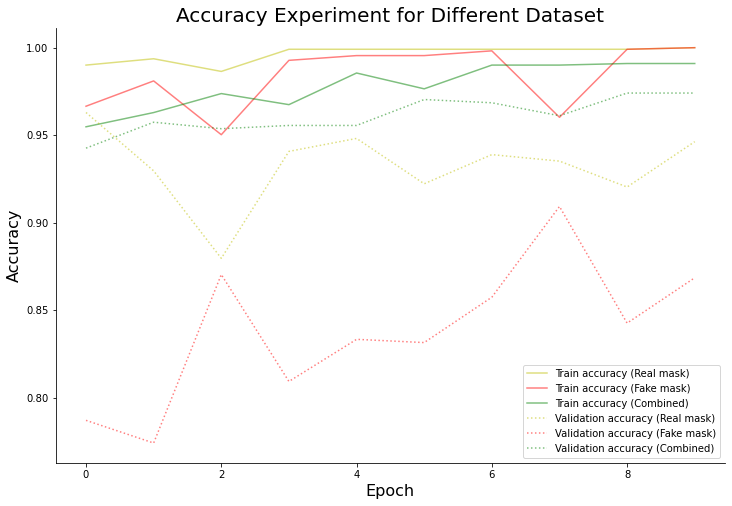

In [112]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(acc_train,color = 'y',label = 'Train accuracy (Real mask)',alpha = 0.5)
ax.plot(acc_train_1,color = 'r',label = 'Train accuracy (Fake mask)',alpha = 0.5)
ax.plot(acc_train_2,color = 'g',label = 'Train accuracy (Combined)',alpha = 0.5)

ax.plot(acc_valid,color = 'y',linestyle = ':',label = 'Validation accuracy (Real mask)',alpha = 0.5)
ax.plot(acc_valid_1,color = 'r',linestyle = ':',label = 'Validation accuracy (Fake mask)',alpha = 0.5)
ax.plot(acc_valid_2,color = 'g',linestyle = ':',label = 'Validation accuracy (Combined)',alpha = 0.5)
ax.legend(loc='best')

ax.set_title('Accuracy Experiment for Different Dataset',size = 20)
ax.set_xlabel('Epoch',size = 16)
ax.set_ylabel('Accuracy',size = 16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()